In [1]:
import numpy as np
import pandas as pd
import nltk
import common_evaluation
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier, LGBMRegressor

# Download NLTK resources (only needs to be done once)
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/i538819/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/i538819/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Load Data and Models

In [2]:
# Load CSV with all pairs
print("Loading CSV...")

# Load your custom split datasets
train_df = pd.read_csv("data/full_dataset.csv")
test_df = pd.read_csv("test_data/test_dataset.csv")

# Paths to multilingual FastText aligned vectors (.vec files)
fasttext_model_paths = {
    'en': 'pretrained_models/fasttext/wiki.en.align.vec',
    'es': 'pretrained_models/fasttext/wiki.es.align.vec',
    'de': 'pretrained_models/fasttext/wiki.de.align.vec',
    'pl': 'pretrained_models/fasttext/wiki.pl.align.vec',
    'tr': 'pretrained_models/fasttext/wiki.tr.align.vec',
    'ar': 'pretrained_models/fasttext/wiki.ar.align.vec',
    'fr': 'pretrained_models/fasttext/wiki.fr.align.vec',
    'it': 'pretrained_models/fasttext/wiki.it.align.vec',
    'ru': 'pretrained_models/fasttext/wiki.ru.align.vec',
    'zh': 'pretrained_models/fasttext/wiki.zh.align.vec',
}

# Load and cache gensim models
fasttext_models = {}
for lang, path in fasttext_model_paths.items():
    print(f"Loading FastText model for {lang}...")
    fasttext_models[lang] = KeyedVectors.load_word2vec_format(path)

Loading CSV...
Loading FastText model for en...
Loading FastText model for es...
Loading FastText model for de...
Loading FastText model for pl...
Loading FastText model for tr...
Loading FastText model for ar...
Loading FastText model for fr...
Loading FastText model for it...
Loading FastText model for ru...
Loading FastText model for zh...


## Preprocessing + Embeddings

In [3]:
def simple_preprocess(text):
    if not isinstance(text, str):
        text = ""
    return word_tokenize(text.lower())

In [4]:
def average_embedding(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

## Feature Extractors

In [5]:
def extract_features_lang_aware(feature_func):
    def wrapped(row):
        lang = row['lang1']
        model = fasttext_models.get(lang)
        if model is None:
            raise ValueError(f"No model found for language: {lang}")
        return feature_func(row, model)
    return wrapped

def extract_title_features(row, model_dict):
    tokens1 = simple_preprocess(row['title1'])
    tokens2 = simple_preprocess(row['title2'])

    vec1 = average_embedding(tokens1, model_dict)
    vec2 = average_embedding(tokens2, model_dict)

    sim = cosine_similarity([vec1], [vec2])[0][0]
    diff = np.abs(vec1 - vec2)
    prod = vec1 * vec2

    return [sim] + diff.tolist() + prod.tolist()

def extract_text_features(row, model):
    tokens1 = simple_preprocess(row['text1'])
    tokens2 = simple_preprocess(row['text2'])

    vec1 = average_embedding(tokens1, model)
    vec2 = average_embedding(tokens2, model)

    sim = cosine_similarity([vec1], [vec2])[0][0]
    diff = np.abs(vec1 - vec2)
    prod = vec1 * vec2

    return [sim] + diff.tolist() + prod.tolist()

def extract_combined_features(row, model):
    # --- Title vector ---
    tokens_title1 = simple_preprocess(row['title1'])
    tokens_title2 = simple_preprocess(row['title2'])
    vec_title1 = average_embedding(tokens_title1, model)
    vec_title2 = average_embedding(tokens_title2, model)
    sim_title = cosine_similarity([vec_title1], [vec_title2])[0][0]
    diff_title = np.abs(vec_title1 - vec_title2)
    prod_title = vec_title1 * vec_title2

    # --- Text vector ---
    tokens_text1 = simple_preprocess(row['text1'])
    tokens_text2 = simple_preprocess(row['text2'])
    vec_text1 = average_embedding(tokens_text1, model)
    vec_text2 = average_embedding(tokens_text2, model)
    sim_text = cosine_similarity([vec_text1], [vec_text2])[0][0]
    diff_text = np.abs(vec_text1 - vec_text2)
    prod_text = vec_text1 * vec_text2

    return ([sim_title] + diff_title.tolist() + prod_title.tolist() +
        [sim_text] + diff_text.tolist() + prod_text.tolist() )

def extract_all_features(row, model):
    structured_cols = ['geography', 'entities', 'time', 'narrative', 'style', 'tone']
    # --- Title vector ---
    tokens_title1 = simple_preprocess(row['title1'])
    tokens_title2 = simple_preprocess(row['title2'])
    vec_title1 = average_embedding(tokens_title1, model)
    vec_title2 = average_embedding(tokens_title2, model)
    sim_title = cosine_similarity([vec_title1], [vec_title2])[0][0]
    diff_title = np.abs(vec_title1 - vec_title2)
    prod_title = vec_title1 * vec_title2

    # --- Text vector ---
    tokens_text1 = simple_preprocess(row['text1'])
    tokens_text2 = simple_preprocess(row['text2'])
    vec_text1 = average_embedding(tokens_text1, model)
    vec_text2 = average_embedding(tokens_text2, model)
    sim_text = cosine_similarity([vec_text1], [vec_text2])[0][0]
    diff_text = np.abs(vec_text1 - vec_text2)
    prod_text = vec_text1 * vec_text2

    # --- Structured features ---
    structured = [row[col] for col in structured_cols]

    # --- Final feature vector ---
    return (
        [sim_title] + diff_title.tolist() + prod_title.tolist() +
        [sim_text] + diff_text.tolist() + prod_text.tolist() +
        structured
    )


## Classification Train/Evaluate Function

In [6]:
def run_classification(train_df, test_df, feature_func, model, description, save_json_file_name=None):
    print(f"\n=== Training classification model: {description} ===")

    # Extract training features and labels
    X_train = [feature_func(row, model) if model else feature_func(row) for _, row in train_df.iterrows()]
    y_train = train_df["overall_classification"].values

    # Extract test features and labels
    X_test = [feature_func(row, model) if model else feature_func(row) for _, row in test_df.iterrows()]
    y_test = test_df["overall_classification"].values

    # Convert to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    # Train classifier
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('lgbm', LGBMClassifier(n_estimators=100, random_state=42))
    ])
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    results = common_evaluation.evaluate_classification(
        y_true=y_test,
        y_pred=y_pred,
        description=description,
        save_json_file_name=save_json_file_name
    )

    return results

## Regression Train/Evaluate

In [7]:
def run_regression(train_df, test_df, feature_func, model, description, save_json_file_name=None):
    print(f"\n=== Running regression on: {description} ===")

    # Extract training features and targets
    X_train = [feature_func(row, model) if model else feature_func(row) for _, row in train_df.iterrows()]
    y_train = train_df["overall"].values

    # Extract test features and targets
    X_test = [feature_func(row, model) if model else feature_func(row) for _, row in test_df.iterrows()]
    y_test = test_df["overall"].values

    # Convert to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    reg = Pipeline([
        ('scaler', StandardScaler()),
        ('lgbm', LGBMRegressor(n_estimators=100, random_state=42))
    ])
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    results = common_evaluation.evaluate_regression(  # assuming this exists in your module
        y_true=y_test,
        y_pred=y_pred,
        description=description,
        save_json_file_name=save_json_file_name
    )

    return results

## Classification with FastText


=== Training classification model: Title Only - Classification ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 2736, number of used features: 601
[LightGBM] [Info] Start training from score -1.685741
[LightGBM] [Info] Start training from score -1.617143
[LightGBM] [Info] Start training from score -1.683771
[LightGBM] [Info] Start training from score -0.842679

Classification Evaluation for Title Only - Classification
Accuracy: 0.368
Precision (weighted): 0.363
Recall (weighted): 0.368
F1 Score (weighted): 0.302

Classification Report:
              precision    recall  f1-score   support

           1      0.472     0.274     0.347       970
           2      0.293     0.136     0.185       885
           3      0.304     0.034     0.062       700
           4      0.360     0

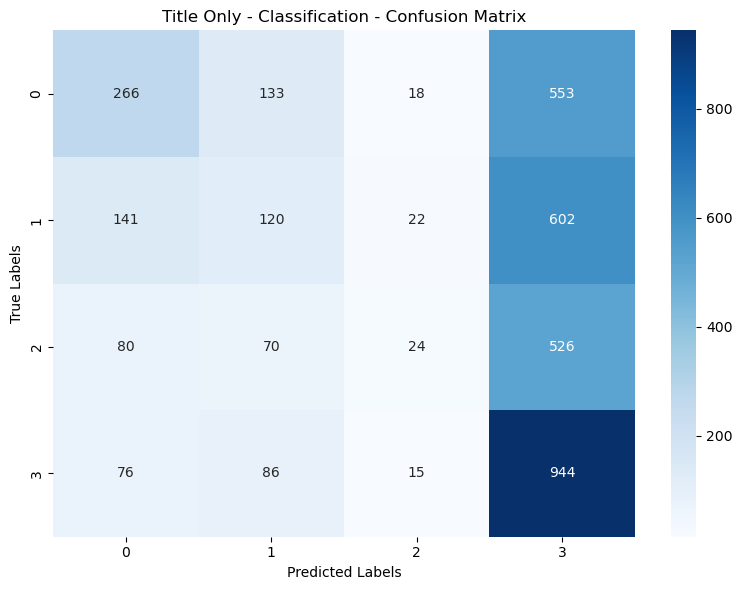

Results saved to: eval_results/title_only_classification.json

=== Training classification model: Text Only - Classification ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 2736, number of used features: 601
[LightGBM] [Info] Start training from score -1.685741
[LightGBM] [Info] Start training from score -1.617143
[LightGBM] [Info] Start training from score -1.683771
[LightGBM] [Info] Start training from score -0.842679

Classification Evaluation for Text Only - Classification
Accuracy: 0.395
Precision (weighted): 0.392
Recall (weighted): 0.395
F1 Score (weighted): 0.342

Classification Report:
              precision    recall  f1-score   support

           1      0.496     0.301     0.375       970
           2      0.345     0.200     0.253       885
           3      0.318

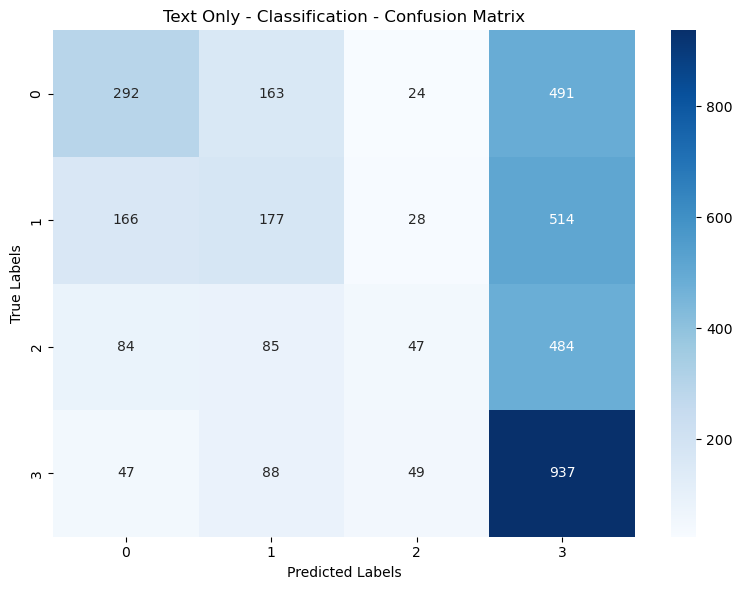

Results saved to: eval_results/text_only_classification.json

=== Training classification model: Title + Text - Classification ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306510
[LightGBM] [Info] Number of data points in the train set: 2736, number of used features: 1202
[LightGBM] [Info] Start training from score -1.685741
[LightGBM] [Info] Start training from score -1.617143
[LightGBM] [Info] Start training from score -1.683771
[LightGBM] [Info] Start training from score -0.842679

Classification Evaluation for Title + Text - Classification
Accuracy: 0.404
Precision (weighted): 0.400
Recall (weighted): 0.404
F1 Score (weighted): 0.354

Classification Report:
              precision    recall  f1-score   support

           1      0.538     0.316     0.398       970
           2      0.356     0.212     0.266       885
           3     

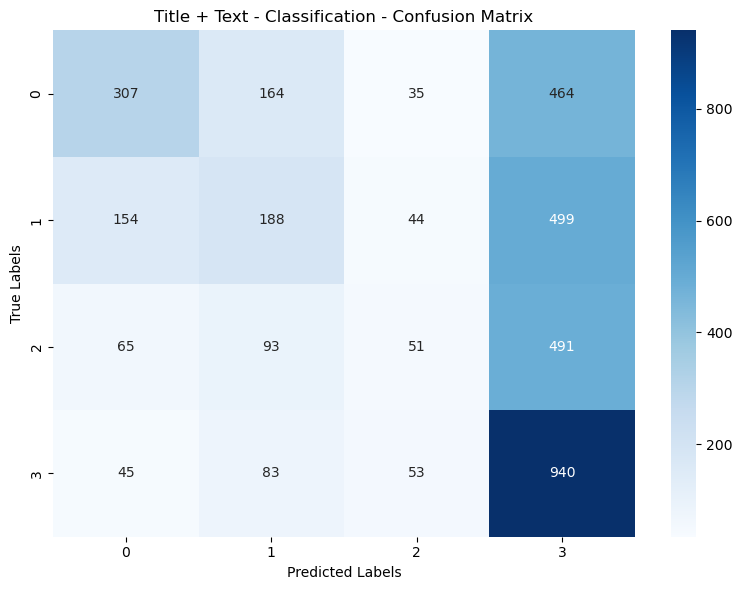

Results saved to: eval_results/title_text_classification.json

=== Training classification model: All Features - Classification ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306630
[LightGBM] [Info] Number of data points in the train set: 2736, number of used features: 1208
[LightGBM] [Info] Start training from score -1.685741
[LightGBM] [Info] Start training from score -1.617143
[LightGBM] [Info] Start training from score -1.683771
[LightGBM] [Info] Start training from score -0.842679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Classification Evaluation for All Features - Classification
Accuracy: 0.724
Precision (weighted): 0.722
Recall (weighted): 0.724
F1 Score (weighted): 0.721

Classification Report:
              precision    recall  f1-score   support

           1      0.806     0.858     0.831      

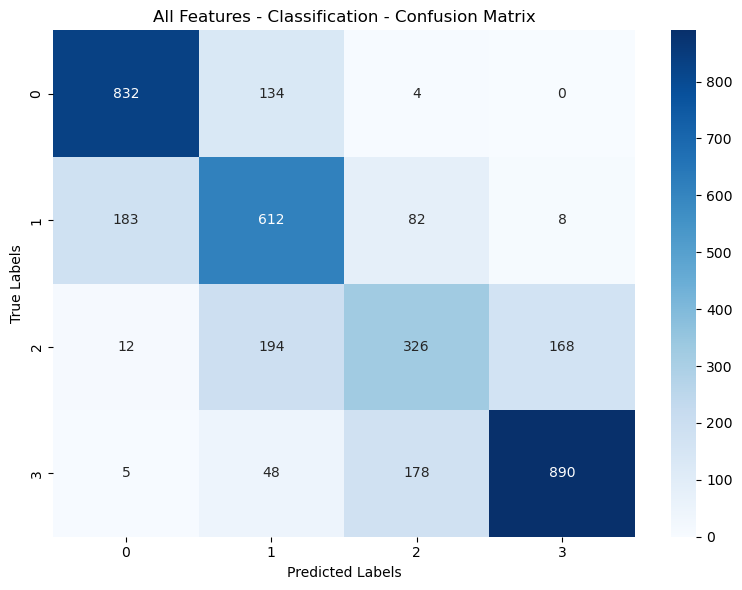

Results saved to: eval_results/all_features_classification.json


In [8]:
classification_results = []

classification_results.append(run_classification(
    train_df, test_df,
    extract_features_lang_aware(extract_title_features),
    None,
    "Title Only - Classification",
    save_json_file_name="title_only_classification.json"
))

classification_results.append(run_classification(
    train_df, test_df,
    extract_features_lang_aware(extract_text_features),
    None,
    "Text Only - Classification",
    save_json_file_name="text_only_classification.json"
))

classification_results.append(run_classification(
    train_df, test_df,
    extract_features_lang_aware(extract_combined_features),
    None,
    "Title + Text - Classification",
    save_json_file_name="title_text_classification.json"
))

classification_results.append(run_classification(
    train_df, test_df,
    extract_features_lang_aware(extract_all_features),
    None,
    "All Features - Classification",
    save_json_file_name="all_features_classification.json"
))

## Regression with FastText


=== Running regression on: Title Only - Regression ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 2736, number of used features: 601
[LightGBM] [Info] Start training from score 2.843277

Regression Evaluation for Title Only - Regression
Mean Squared Error (MSE): 1.557
Mean Absolute Error (MAE): 1.031
R2 Score: -0.135
Pearson Correlation (r): 0.244


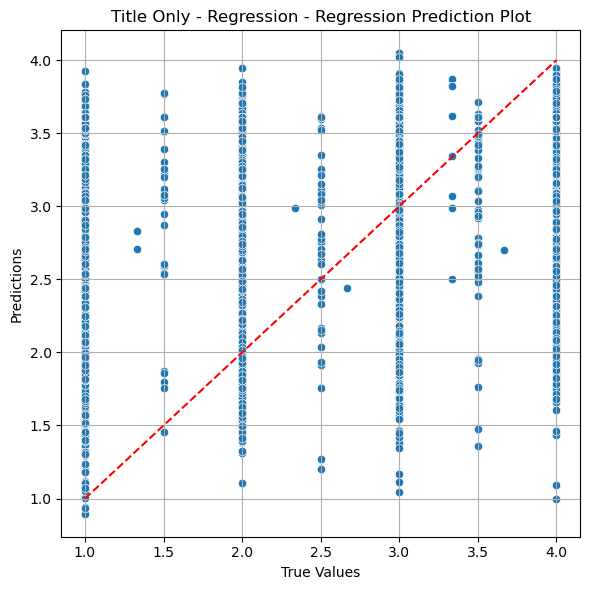

Results saved to: eval_results/title_only_regression.json

=== Running regression on: Text Only - Regression ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 2736, number of used features: 601
[LightGBM] [Info] Start training from score 2.843277

Regression Evaluation for Text Only - Regression
Mean Squared Error (MSE): 1.342
Mean Absolute Error (MAE): 0.948
R2 Score: 0.022
Pearson Correlation (r): 0.341


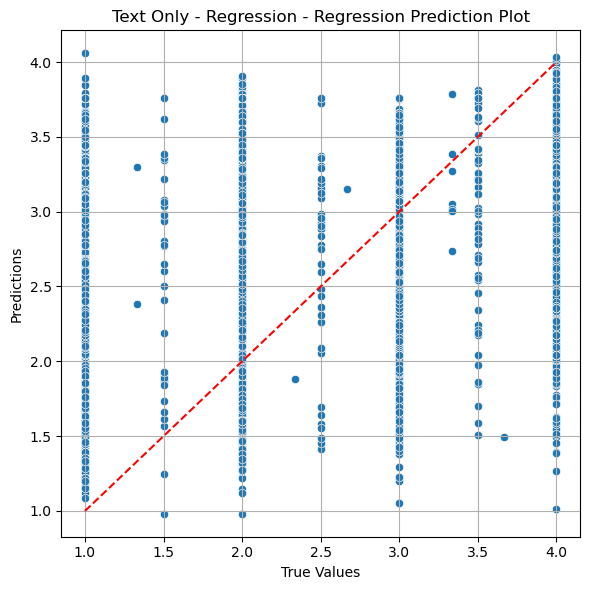

Results saved to: eval_results/text_only_regression.json

=== Running regression on: Title + Text - Regression ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306510
[LightGBM] [Info] Number of data points in the train set: 2736, number of used features: 1202
[LightGBM] [Info] Start training from score 2.843277

Regression Evaluation for Title + Text - Regression
Mean Squared Error (MSE): 1.364
Mean Absolute Error (MAE): 0.946
R2 Score: 0.005
Pearson Correlation (r): 0.372


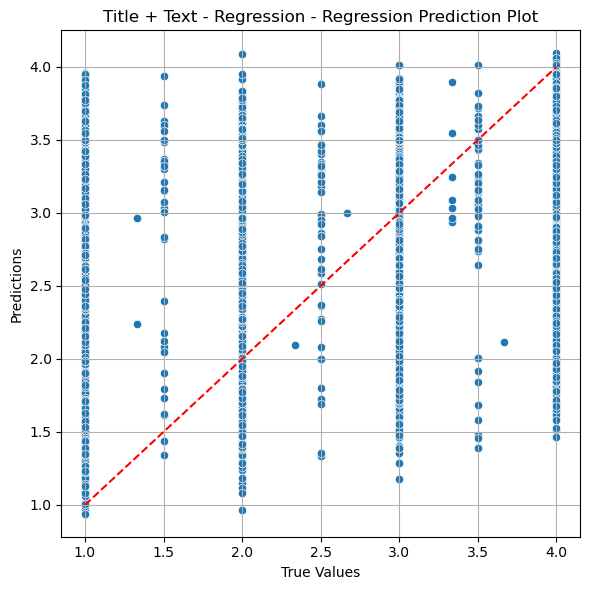

Results saved to: eval_results/title_text_regression.json

=== Running regression on: All Features - Regression ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306630
[LightGBM] [Info] Number of data points in the train set: 2736, number of used features: 1208
[LightGBM] [Info] Start training from score 2.843277

Regression Evaluation for All Features - Regression
Mean Squared Error (MSE): 0.245
Mean Absolute Error (MAE): 0.346
R2 Score: 0.822
Pearson Correlation (r): 0.909


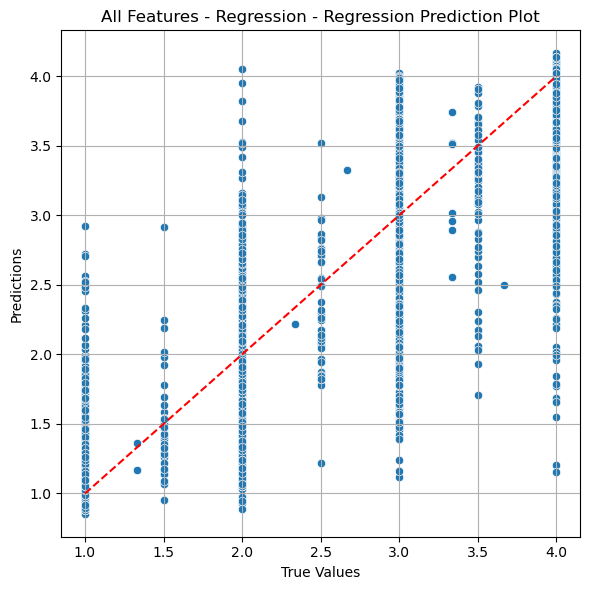

Results saved to: eval_results/all_features_regression.json


In [9]:
regression_results = []

regression_results.append(run_regression(
    train_df, test_df,
    extract_features_lang_aware(extract_title_features),
    None,
    "Title Only - Regression",
    save_json_file_name="title_only_regression.json"
))

regression_results.append(run_regression(
    train_df, test_df,
    extract_features_lang_aware(extract_text_features),
    None,
    "Text Only - Regression",
    save_json_file_name="text_only_regression.json"
))

regression_results.append(run_regression(
    train_df, test_df,
    extract_features_lang_aware(extract_combined_features),
    None,
    "Title + Text - Regression",
    save_json_file_name="title_text_regression.json"
))

regression_results.append(run_regression(
    train_df, test_df,
    extract_features_lang_aware(extract_all_features),
    None,
    "All Features - Regression",
    save_json_file_name="all_features_regression.json"
))


## FastText Classification vs. Regression

In [10]:
# Convert to DataFrame
results_df = pd.DataFrame(classification_results)
display(results_df)

results_df2 = pd.DataFrame(regression_results)
display(results_df2)


,Model,Accuracy,Precision,Recall,F1 Score
0,Title Only - Classification,0.368335,0.362825,0.368335,0.301655
1,Text Only - Classification,0.395267,0.392138,0.395267,0.342034
2,Title + Text - Classification,0.404244,0.400402,0.404244,0.354303
3,All Features - Classification,0.723613,0.721685,0.723613,0.721099


,Model,MSE,MAE,R2,Pearson Correlation
0,Title Only - Regression,1.556654,1.030688,-0.134872,0.243834
1,Text Only - Regression,1.341825,0.948121,0.021748,0.340574
2,Title + Text - Regression,1.364380,0.946414,0.005304,0.372340
3,All Features - Regression,0.244831,0.346065,0.821507,0.909131


# English only documents


=== Training classification model: Title Only - Classification ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 601
[LightGBM] [Info] Start training from score -1.857499
[LightGBM] [Info] Start training from score -1.701153
[LightGBM] [Info] Start training from score -1.637437
[LightGBM] [Info] Start training from score -0.761454

Classification Evaluation for Title Only - Classification
Accuracy: 0.541
Precision (weighted): 0.569
Recall (weighted): 0.541
F1 Score (weighted): 0.522

Classification Report:
              precision    recall  f1-score   support

           1      0.692     0.450     0.545        60
           2      0.550     0.306     0.393        36
           3      0.478     0.379     0.423        29
           4      0.495     0

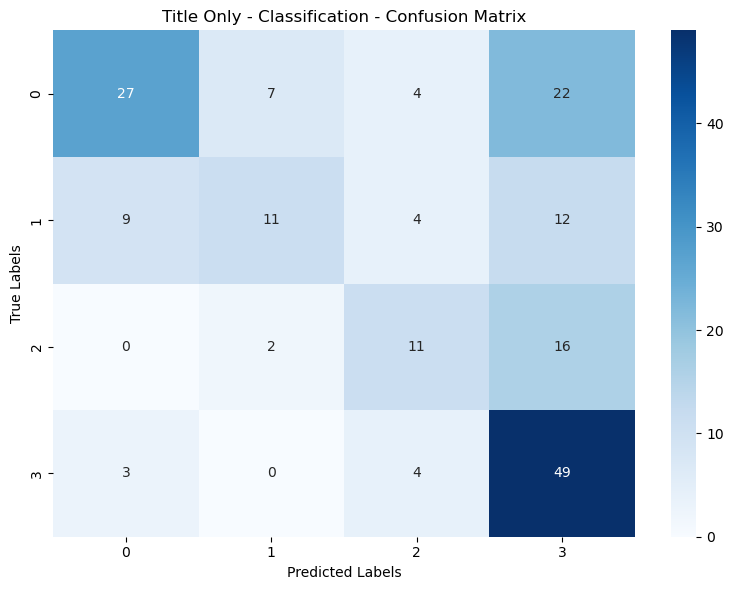

Results saved to: eval_results/title_only_classification.json

=== Training classification model: Text Only - Classification ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 601
[LightGBM] [Info] Start training from score -1.857499
[LightGBM] [Info] Start training from score -1.701153
[LightGBM] [Info] Start training from score -1.637437
[LightGBM] [Info] Start training from score -0.761454

Classification Evaluation for Text Only - Classification
Accuracy: 0.547
Precision (weighted): 0.554
Recall (weighted): 0.547
F1 Score (weighted): 0.535

Classification Report:
              precision    recall  f1-score   support

           1      0.658     0.417     0.510        60
           2      0.410     0.444     0.427        36
           3      0.423

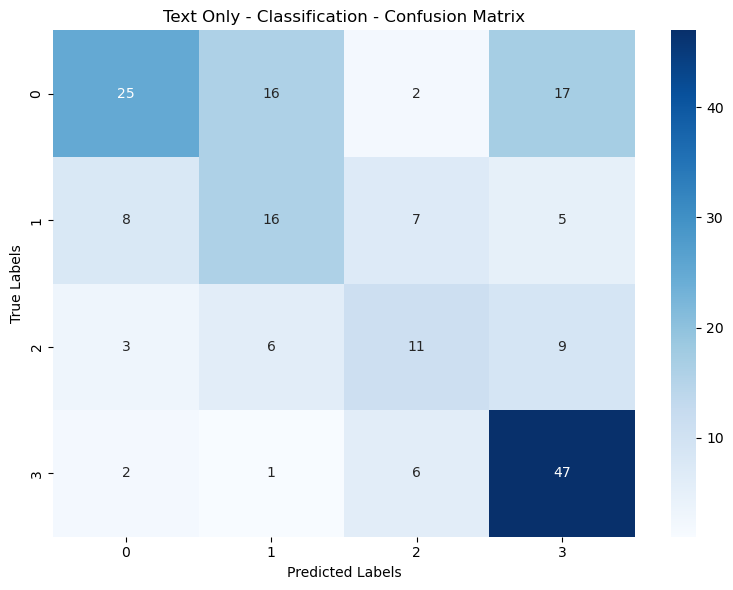

Results saved to: eval_results/text_only_classification.json

=== Training classification model: Title + Text - Classification ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306510
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 1202
[LightGBM] [Info] Start training from score -1.857499
[LightGBM] [Info] Start training from score -1.701153
[LightGBM] [Info] Start training from score -1.637437
[LightGBM] [Info] Start training from score -0.761454

Classification Evaluation for Title + Text - Classification
Accuracy: 0.580
Precision (weighted): 0.590
Recall (weighted): 0.580
F1 Score (weighted): 0.569

Classification Report:
              precision    recall  f1-score   support

           1      0.711     0.450     0.551        60
           2      0.400     0.389     0.394        36
           3     

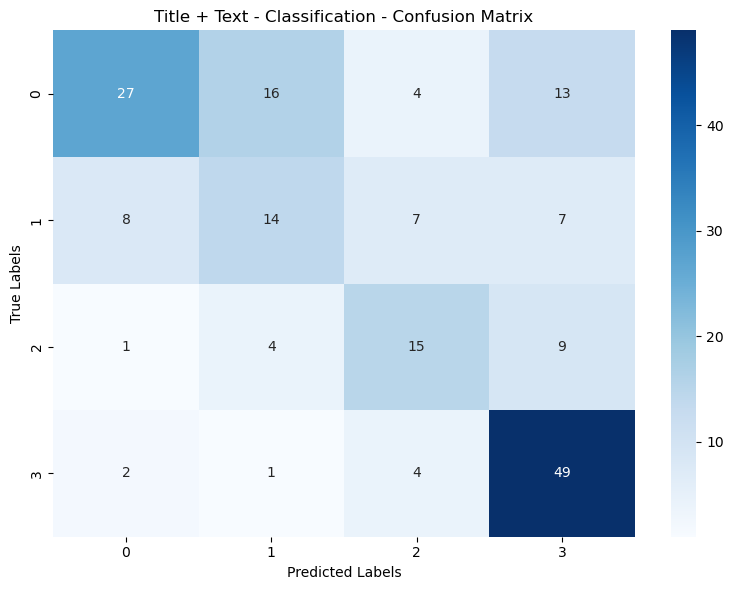

Results saved to: eval_results/title_text_classification.json


In [11]:
train_df = train_df[(train_df['lang1'] == 'en') & (train_df['lang2'] == 'en')].reset_index(drop=True)
test_df = test_df[(test_df['lang1'] == 'en') & (test_df['lang2'] == 'en')].reset_index(drop=True)

classification_results_en = []

classification_results_en.append(run_classification(
    train_df, test_df,
    extract_features_lang_aware(extract_title_features),
    None,
    "Title Only - Classification",
    save_json_file_name="title_only_classification.json"
))

classification_results_en.append(run_classification(
    train_df, test_df,
    extract_features_lang_aware(extract_text_features),
    None,
    "Text Only - Classification",
    save_json_file_name="text_only_classification.json"
))

classification_results_en.append(run_classification(
    train_df, test_df,
    extract_features_lang_aware(extract_combined_features),
    None,
    "Title + Text - Classification",
    save_json_file_name="title_text_classification.json"
))



=== Running regression on: Title Only - Regression ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 601
[LightGBM] [Info] Start training from score 2.954805

Regression Evaluation for Title Only - Regression
Mean Squared Error (MSE): 0.999
Mean Absolute Error (MAE): 0.773
R2 Score: 0.328
Pearson Correlation (r): 0.640


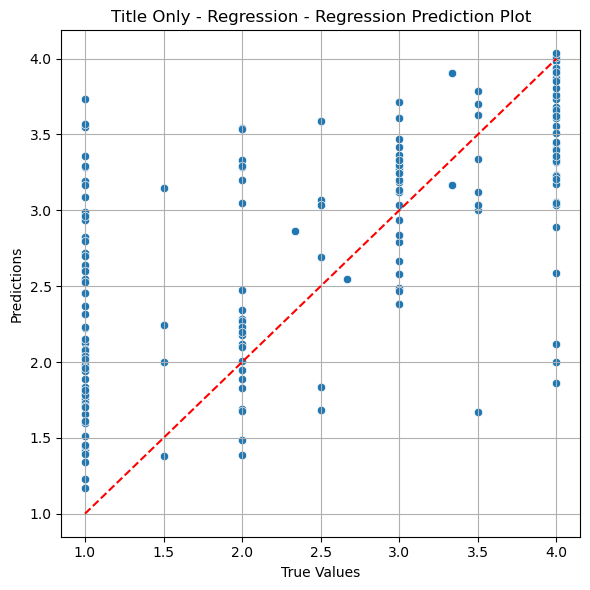

Results saved to: eval_results/title_only_regression.json

=== Running regression on: Text Only - Regression ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153255
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 601
[LightGBM] [Info] Start training from score 2.954805

Regression Evaluation for Text Only - Regression
Mean Squared Error (MSE): 0.939
Mean Absolute Error (MAE): 0.724
R2 Score: 0.368
Pearson Correlation (r): 0.649


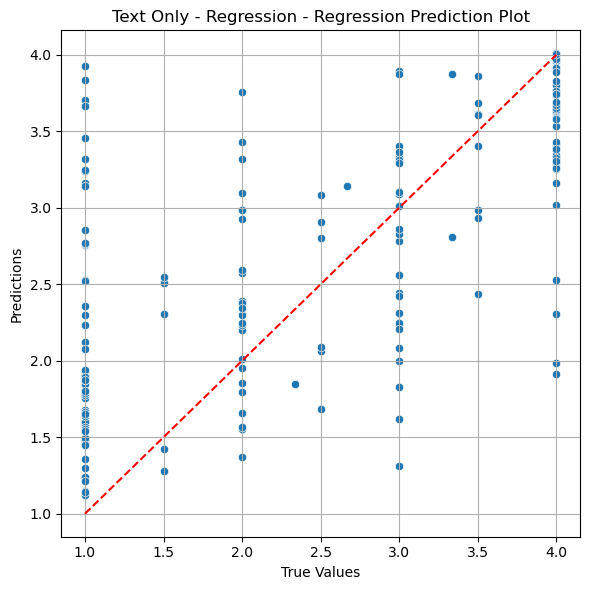

Results saved to: eval_results/text_only_regression.json

=== Running regression on: Title + Text - Regression ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 306510
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 1202
[LightGBM] [Info] Start training from score 2.954805

Regression Evaluation for Title + Text - Regression
Mean Squared Error (MSE): 0.841
Mean Absolute Error (MAE): 0.689
R2 Score: 0.435
Pearson Correlation (r): 0.696


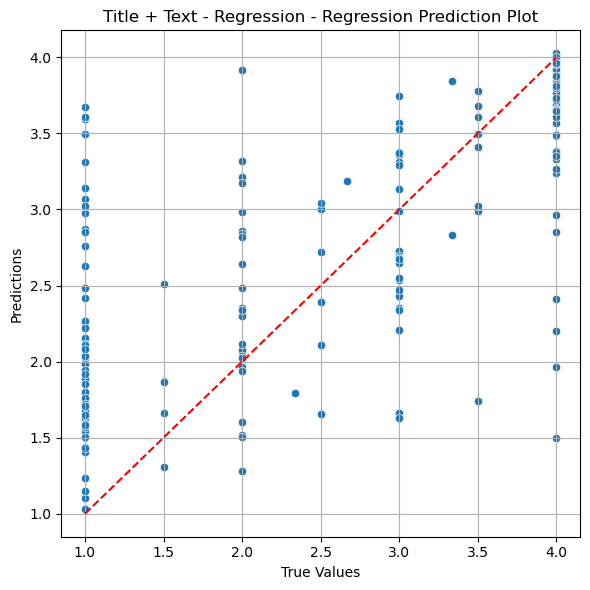

Results saved to: eval_results/title_text_regression.json


In [12]:
regression_results_en = []

regression_results_en.append(run_regression(
    train_df, test_df,
    extract_features_lang_aware(extract_title_features),
    None,
    "Title Only - Regression",
    save_json_file_name="title_only_regression.json"
))

regression_results_en.append(run_regression(
    train_df, test_df,
    extract_features_lang_aware(extract_text_features),
    None,
    "Text Only - Regression",
    save_json_file_name="text_only_regression.json"
))

regression_results_en.append(run_regression(
    train_df, test_df,
    extract_features_lang_aware(extract_combined_features),
    None,
    "Title + Text - Regression",
    save_json_file_name="title_text_regression.json"
))

In [13]:
# Convert to DataFrame
results_df = pd.DataFrame(classification_results_en)
display(results_df)

results_df2 = pd.DataFrame(regression_results_en)
display(results_df2)


,Model,Accuracy,Precision,Recall,F1 Score
0,Title Only - Classification,0.541436,0.568648,0.541436,0.522353
1,Text Only - Classification,0.546961,0.553899,0.546961,0.535115
2,Title + Text - Classification,0.580110,0.589564,0.580110,0.568836


,Model,MSE,MAE,R2,Pearson Correlation
0,Title Only - Regression,0.998950,0.772650,0.328104,0.640294
1,Text Only - Regression,0.939175,0.723730,0.368309,0.648773
2,Title + Text - Regression,0.840683,0.688897,0.434555,0.696179
